#CCE Classifier on toy dataset

In [1]:
pip install deel-lip -qqq

     |████████████████████████████████| 462 kB 6.2 MB/s 


In [16]:
import numpy as np
from sklearn.datasets import make_moons, make_circles  # the synthetic dataset
import matplotlib.pyplot as plt 
import seaborn as sns


# in order to build our classifier we will use element from tensorflow along with
# layers from deel-lip
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import ReLU, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import binary_accuracy

from deel.lip.model import Model
from deel.lip.layers import SpectralConv2D, SpectralDense, FrobeniusDense
from deel.lip.activations import MaxMin, GroupSort, FullSort, GroupSort2

from tensorflow.keras.losses import binary_crossentropy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import gridspec

### Parameters 

Let's first construct our two moons dataset

In [17]:
circle_or_moons = 1  # 0 for circle , 1 for moons
n_samples=5000  # number of sample in the dataset
noise=0.05  # amount of noise to add in the data. Tested with 0.14 for circles 0.05 for two moons
factor=0.4  # scale factor between the inner and the outer circle

In [18]:
if circle_or_moons == 0:
    X, Y = make_circles(n_samples=n_samples, noise=noise, factor=factor)
else:
    X, Y = make_moons(n_samples=n_samples, noise=noise)

Y = tf.one_hot(Y,2)

### Build lipschitz Model

Let's build our model now.

In [19]:
batch_size = 1024
steps_per_epoch = 40480
epoch = 10
activation = GroupSort2

In [20]:
K.clear_session()
inputs = Input((2,))
x = SpectralDense(256, activation=activation())(inputs)
x = SpectralDense(128, activation=activation())(x)
x = SpectralDense(64, activation=activation())(x)
y = FrobeniusDense(2, activation=None)(x)
model_1 = Model(inputs=inputs, outputs=y)
tau_1 = 0.5

model_1.compile(
    loss=lambda y_true, y_pred:binary_crossentropy(y_true, tau_1*y_pred, from_logits=True),
    metrics=["accuracy"],
    optimizer=Adam(0.001)
)

model_1.fit(
    x=X,
    y=Y,
    steps_per_epoch=steps_per_epoch // batch_size, 
    epochs=20,
    verbose=False
)

In [21]:
K.clear_session()
inputs = Input((2,))
x = SpectralDense(256, activation=activation())(inputs)
x = SpectralDense(128, activation=activation())(x)
x = SpectralDense(64, activation=activation())(x)
y = FrobeniusDense(2, activation=None)(x)
model_2 = Model(inputs=inputs, outputs=y)
tau_2 = 5


model_2.compile(
    loss=lambda y_true, y_pred:binary_crossentropy(y_true, tau_2*y_pred, from_logits=True),
    metrics=["accuracy"],
    optimizer=Adam(0.001)
)

model_2.fit(
    x=X,
    y=Y,
    steps_per_epoch=steps_per_epoch // batch_size, 
    epochs=20,
    verbose=False
)

In [22]:
K.clear_session()
inputs = Input((2,))
x = SpectralDense(256, activation=activation())(inputs)
x = SpectralDense(128, activation=activation())(x)
x = SpectralDense(64, activation=activation())(x)
y = FrobeniusDense(2, activation=None)(x)
model_3 = Model(inputs=inputs, outputs=y)
tau_3 = 10

model_3.compile(
    loss = lambda y_true, y_pred:binary_crossentropy(y_true, tau_3*y_pred, from_logits=True),
    metrics=["accuracy"],
    optimizer=Adam(0.001)
)

model_3.fit(
    x=X,
    y=Y,
    steps_per_epoch=steps_per_epoch // batch_size, 
    epochs=20,
    verbose=False
)

In [23]:
def plot_contour(models, taus, scale=1.0):
  if not isinstance(models, list):
    models = [models]
  plt.clf()
  fig = plt.figure(figsize=(10*scale,3*scale), dpi=300)
  gs = gridspec.GridSpec(2, 3, width_ratios=[1,1,1],
         wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.17, right=0.845)

  for i, model in enumerate(models):
    batch_size=1024

    x = np.linspace(X[:,0].min()-0.2, X[:,0].max()+0.2, 120)
    y = np.linspace(X[:,1].min()-0.2, X[:,1].max()+0.2, 120)
    xx, yy = np.meshgrid(x, y, sparse=False)
    X_pred=np.stack((xx.ravel(),yy.ravel()),axis=1)
    # make predictions of f
    pred=model.predict(X_pred)

    Y_pred=pred[:,0] - pred[:,1]
    Y_pred=Y_pred.reshape(x.shape[0],y.shape[0])
    preds_dataset = model.predict(X)
    preds_dataset_0 = preds_dataset[Y[:,0]==1, 0] - preds_dataset[Y[:,0]==1, 1]
    preds_dataset_1 = preds_dataset[Y[:,0]==0, 0] - preds_dataset[Y[:,0]==0, 1]

    #plot the results
    ax1 = plt.subplot(gs[0,i])
    ax3 = plt.subplot(gs[1,i])

    sns.scatterplot(X[Y[:, 0]==1,0],X[Y[:, 0]==1,1],alpha=0.1,ax=ax1)
    sns.scatterplot(X[Y[:, 0]==0,0],X[Y[:, 0]==0,1],alpha=0.1,ax=ax1)

    pal = sns.diverging_palette(250, 250, l=75, center="dark", as_cmap=True)
    pal2 = sns.dark_palette("#69d", reverse=True, as_cmap=True)
    cset = ax1.contour(xx,yy,Y_pred,cmap=pal, levels=np.linspace(-3., 3., 21))
    ax1.clabel(cset, inline=1, fontsize=10)
    cset = ax1.contour(xx,yy,Y_pred, cmap=pal2, levels=[0], linewidths=4.0)
    ax1.clabel(cset, inline=1, fontsize=10)
    ax1.set(yticklabels=[])
    ax1.set(xticklabels=[])
    ax1.set_title(f"$\\tau={taus[i]}$")

    # robustness plot
    preds = model(X)
    advs = (preds[:, 0] - preds[:, 1]) * (Y[:, 0] - Y[:, 1])
    x_plot = np.linspace(0., 3., 1000)
    y_plot = np.interp(x=x_plot, xp=np.sort(advs), fp=np.linspace(1.,0.,len(X)))

    sns.lineplot(x=x_plot, y=y_plot, color ="#69d", ax=ax3)
    ax3.set_ylim(0, 1.)
    ax3.grid(True)
    if i == 0:
      ax3.set_ylabel('accuracy', fontsize=18)
    else:
      ax3.set(yticklabels=[])
    if i == 1:
      ax3.set_xlabel(r'perturbation radius $\epsilon$', fontsize=18)
  return fig

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

<Figure size 432x288 with 0 Axes>

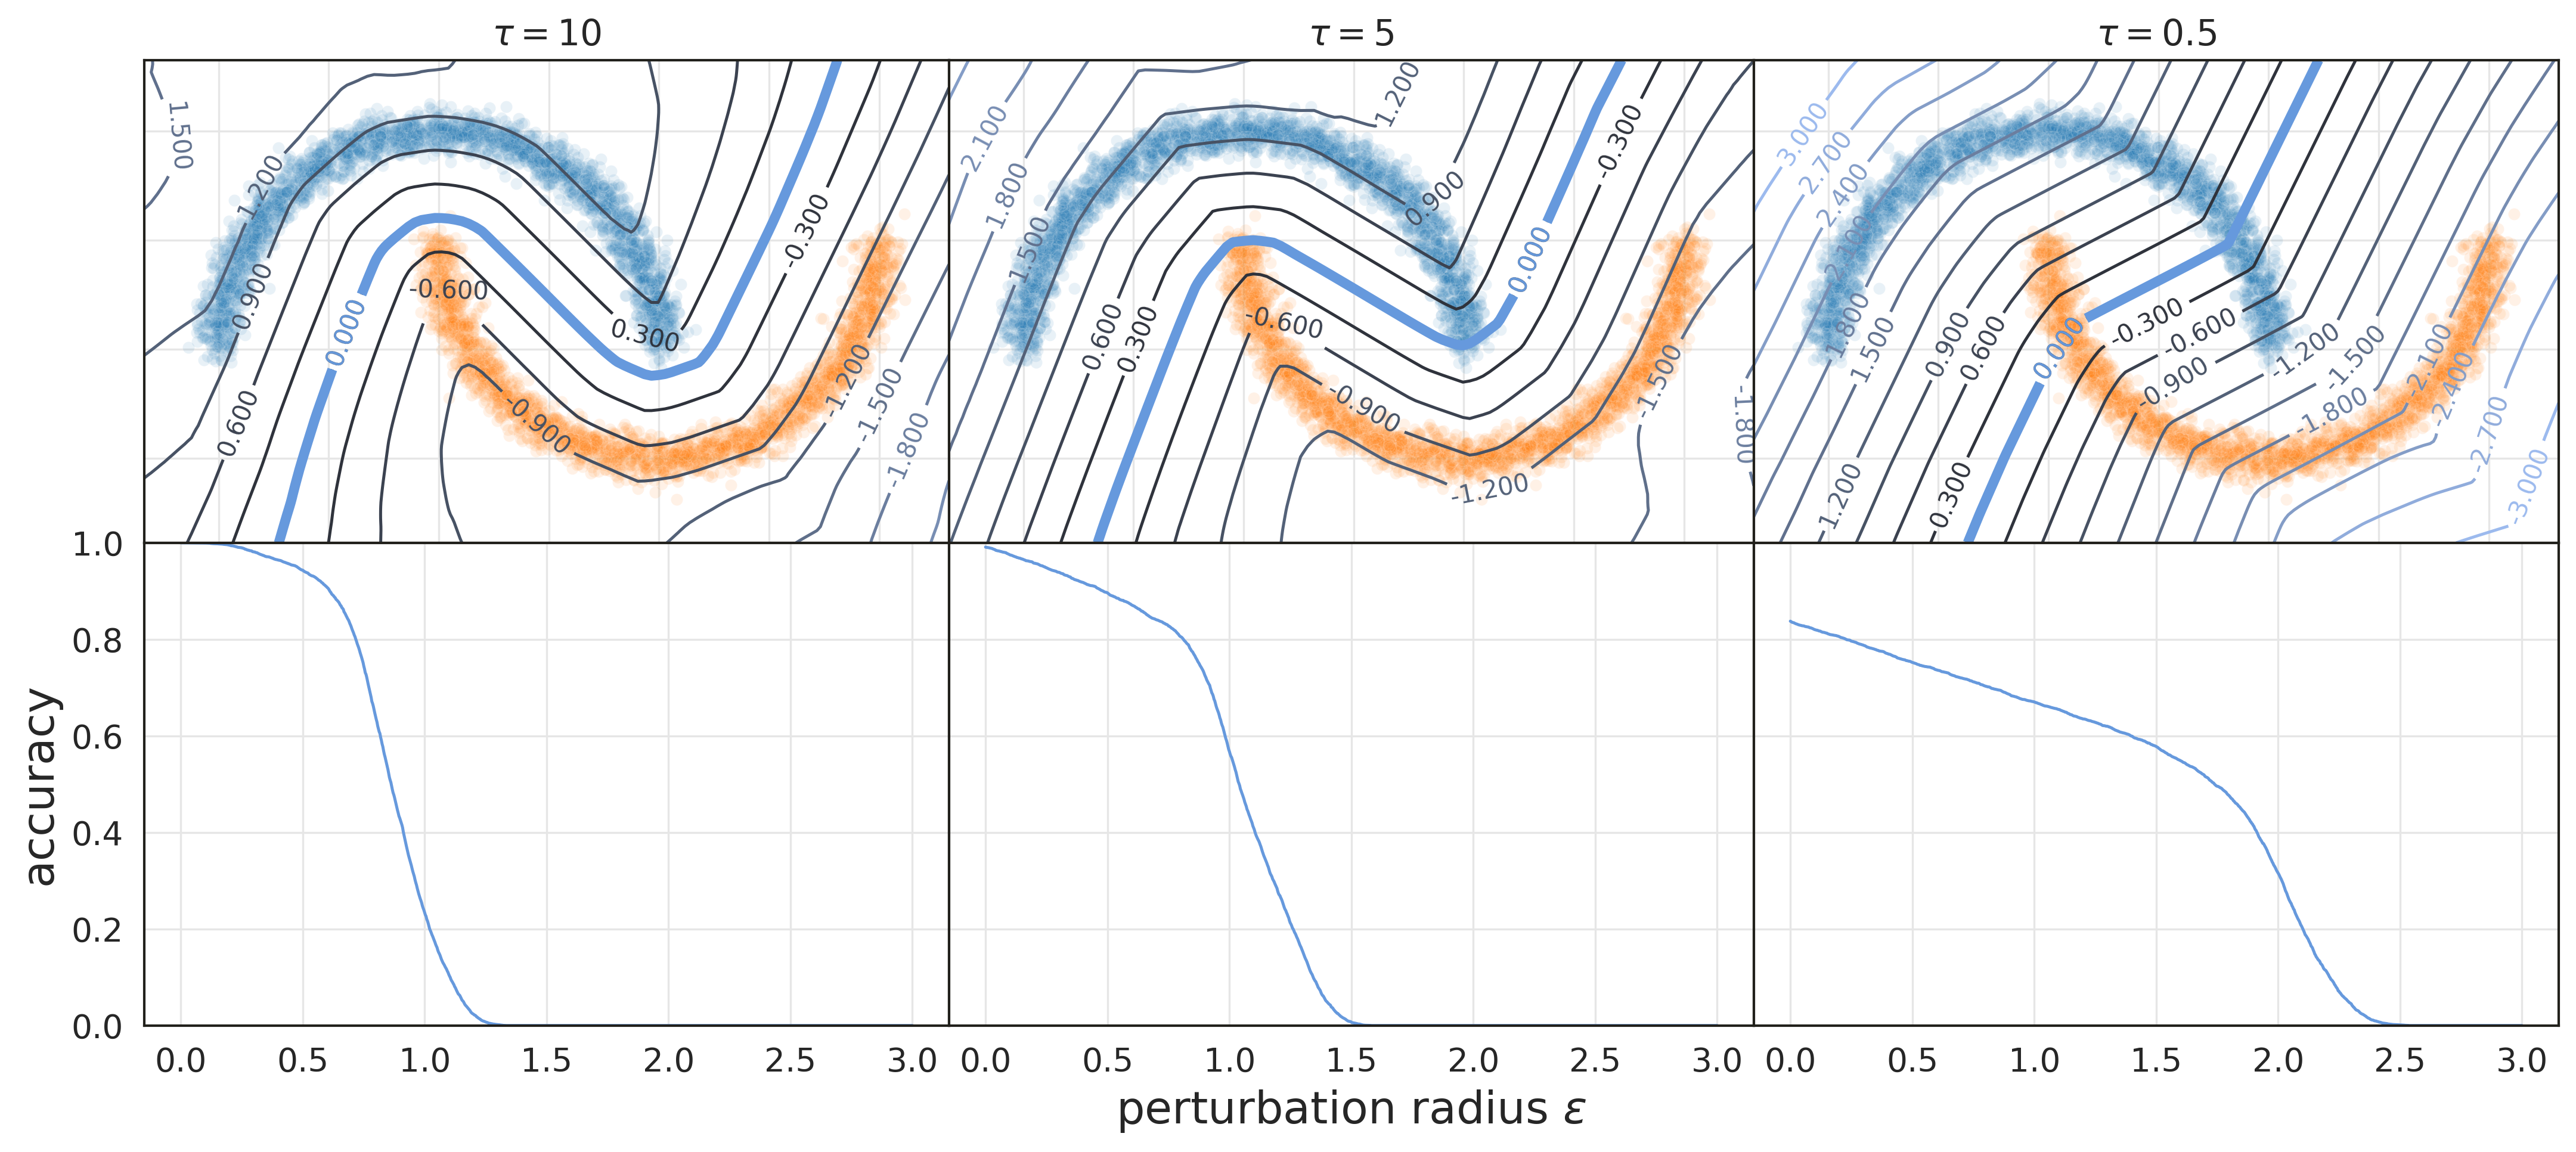

In [24]:
sns.set_context('paper', font_scale = 1.5)
sns.set_style('whitegrid', {"grid.color": ".9", 'axes.edgecolor':'#21201B'})
_ = plot_contour([model_3, model_2, model_1], [tau_3, tau_2, tau_1], scale=2.0)